## Air quality in underground stations

In underground stations, a correlation exists between train circulation and particulate matter pollution, as can be observed from Figure 3.18 in the book, where the average train traffic and the underground PM10 concentration are plotted.

This notebook fits a model on a normalized PM10 data set originating from Paris’ Gare du Nord station. 

The evolution of concentration over time is supposed to depend on the train traffic `N`, the ventilation, the particle deposition. The model we want to fit is described here by the equation : 

$  \frac{\partial C}{\partial t} = \alpha N^2 + (\beta N + \tau)(C_e - C) - \delta C $ where $C$ is the particule concentration, $C_e$ the outdoor particle concentration, $\beta$ the fraction of the station's volume replaced by outside air per train, $\delta C$ the bulk deposition, $\tau$ the air change rate caused by natural ventilation, $\alpha$ an emission factor. 

The objective is to find the optimal values of $\alpha, \beta, \tau, \delta$ to fit the dataset.


Color definition and imports

In [14]:
# -*- coding: utf-8 -*-
# quelques couleurs
rouge_A, vert1_A, vert2_A, vert3_A, vert4_A, gris1_A = '#C60C2E', '#005157', '#627D77', '#9EB28F', '#C5E5A4', '#595A5C'
coule = [rouge_A, vert1_A, vert2_A, vert3_A, vert4_A, gris1_A]

from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

dataset_basepath = "https://raw.githubusercontent.com/eddes/buildingphysics/master/chapter_3/"


### Crank Nicolson scheme and function definition

The Crank Nicolson scheme is defined as per previous equation. The function calculates the temporal evolution of particles concentration over time using the CN scheme. A loss is then computed as the difference between the dataset and the simulated values. 

In [15]:


# Crank-Nicolson scheme for air pollution equation in the underground
def fc_crank_nicolson(Cp, C, dt, alpha, beta, tau, delta, N, Ce):
    term_C = dt * (alpha * N ** 2 + (beta * N + tau) * (Ce - C) - delta * C)
    term_Cp = dt * (alpha * N ** 2 + (beta * N + tau) * (Ce - Cp) - delta * Cp)
    return -Cp + C + 0.5 * term_C + 0.5 * term_Cp

# the minimisation function
def simulation_run(x):
    alpha, beta, delta, tau = x
    dt = 0.25  # 1/h time step
    #measured values
    time_meas = np.loadtxt(dataset_basepath+"time") # the time at which measurements were taken
    sim_time = max(time_meas) # the simulation time corresponds to measurements
    traffic = np.loadtxt(dataset_basepath+"traffic") # train traffic (#/h)
    PM10 = np.loadtxt(dataset_basepath+"PM10") # normalised PM10
    PM10 = PM10 * 100 # ... let's scale them to 100
    Ce = 15 # outdoor PM10
    C = PM10[0] # initialise with the measurement
    t, i = min(time_meas), 0
    time, concentration = [], []
    while t <= max(time_meas):
        time.append(t)
        concentration.append(C)
        N = traffic[i]
        # solve for C+, the concentration at the next time step
        Cp = fsolve(fc_crank_nicolson, C, args=(C, dt, alpha, beta, tau, delta, N, Ce))
        C = Cp
        t += dt
        i += 1

    PM10 = np.asarray(PM10)
    concentration = np.asarray(concentration)
    dC = abs(concentration - PM10)
    return time, concentration, np.mean(dC)

def function_to_minimize(x):
    _, _, loss =  simulation_run(x)
    return loss


### Function minimization

The optimization is performed here using using a Truncated Newton method with initial values picked in a predefined range.  For each step, fc_to_minize runs a simulation and calculate the loss function. `x0` is the initial parameters values. Bounds are the value range allowed for these parameters. 

In [19]:

# setting the bounds for the parameters
#           alpha      beta     delta      tau
bnds = ((0.2, 0.5), (0.05, 0.2), (0.01, 10), (0.1, 1))
k = 0.5 # starting point in the middle of all bounds
x0 = [k * (bnds[0][0] + bnds[0][1]),
      k * (bnds[1][0] + bnds[1][1]),
      k * (bnds[2][0] + bnds[2][1]),
      k * (bnds[3][0] + bnds[3][1])]
#minimisation procedure
sol = minimize(function_to_minimize, x0, bounds=bnds, method='TNC', tol=1e-3)


/home/ysc/.local/share/virtualenvs/bdphysics-24hdeN5V/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


alpha	, beta	, delta	, tau
[0.26020381 0.19993248 0.1434539  0.6579116 ]
mean error 4.97  [µg/m3]


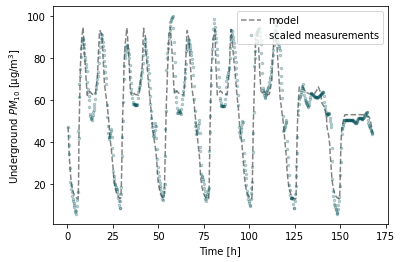

In [18]:
# now let us plot the results
alpha, beta, delta, tau = sol.x[0], sol.x[1], sol.x[2], sol.x[3]
# this time we want to plot and get the concentration in return of min_func

time, concentration, mean_error = simulation_run([alpha, beta, delta, tau])
print("alpha\t, beta\t, delta\t, tau")
print(sol.x)
print("mean error", round(mean_error[0], 2), " [µg/m3]")

PM10 = np.loadtxt(dataset_basepath+"PM10")
PM10 = PM10 * 100
plt.clf()
plt.xlabel(r"Time [h]")
plt.ylabel(r"Underground $PM_{10}$ [µg/m$^3$]")
plt.plot(time, concentration, color=coule[-1], linestyle="--", alpha=0.75, marker='', label='model')
plt.plot(time, PM10, color=coule[1], linestyle="", alpha=0.25, marker='o', markersize='2.5', label='scaled measurements')
plt.legend()
plt.show()


### Optimization visualisation
Let's modify slightly the `fc_to_minimize_wloss` method to extract the loss values over time, as well as the equation parameters. The evolution of the loss over the minimization process is displayed below. 


In [28]:
loss_array = [] # Log the mean_diff quantity
alpha = [] # Log the penaly quantity
beta = [] # Log BP values
tau = [] # Log Tn values
delta = [] # Log Td values

def fc_to_minimize_wloss(x):
    _, _, loss = simulation_run(x)
    loss_array.append(loss[0])
    alpha.append(x[0])
    beta.append(x[1])
    tau.append(x[2])
    delta.append(x[3])

    return loss
sol = minimize(fc_to_minimize_wloss, x0, bounds=bnds, method='TNC', tol=1e-3)

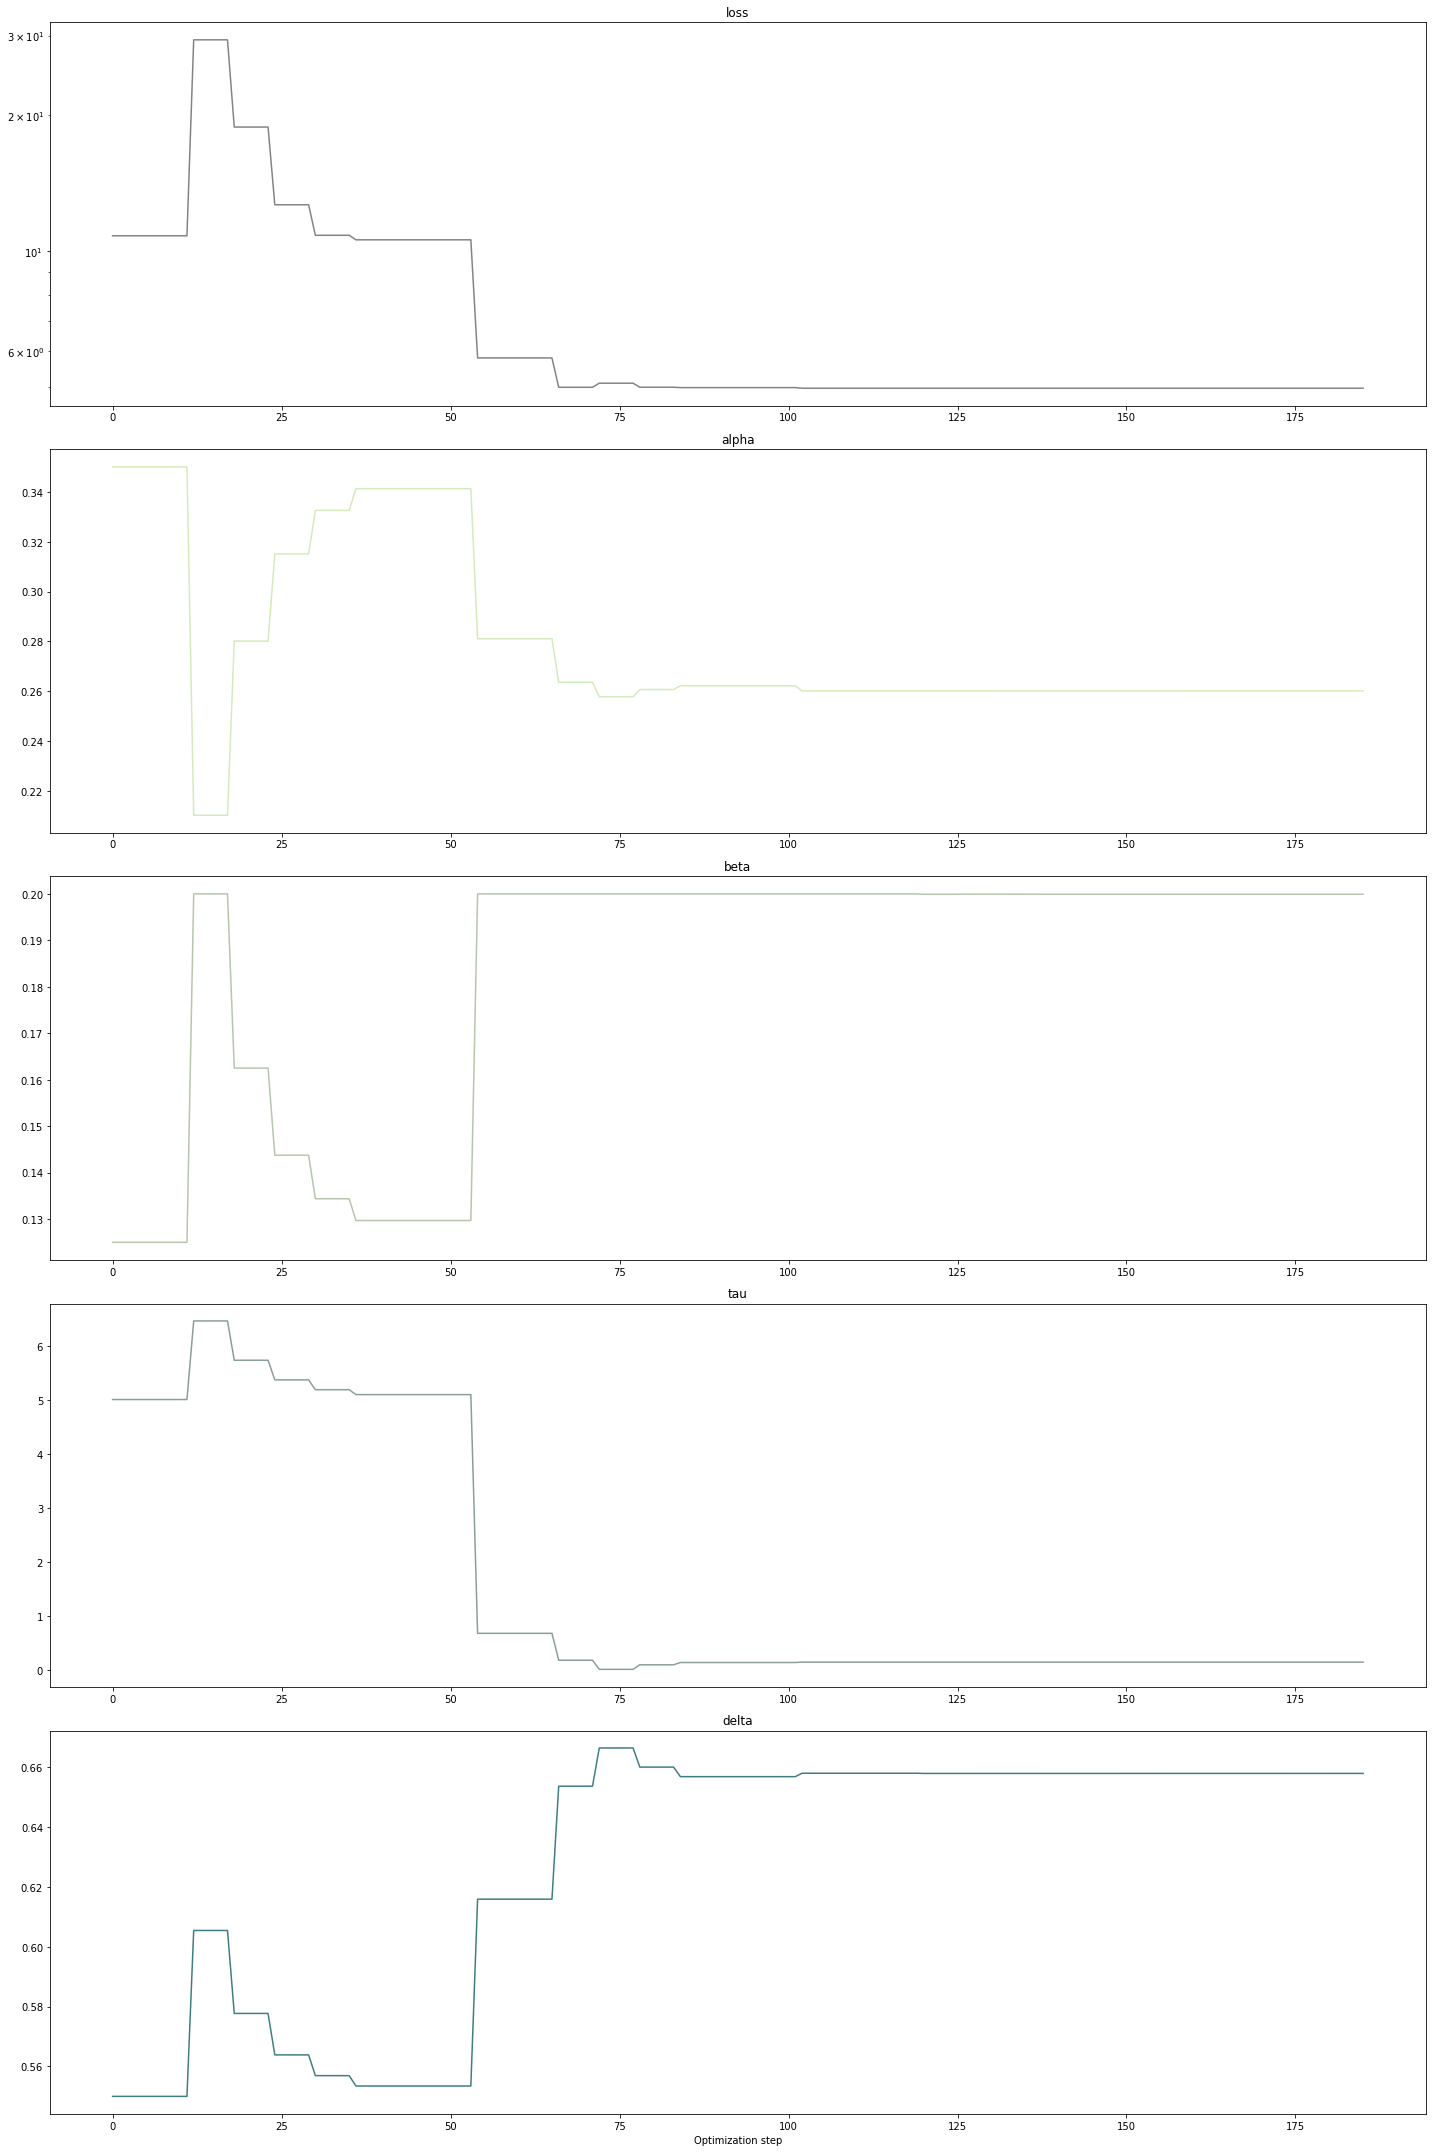

In [29]:
plt.rcParams["figure.figsize"] = (20,30)

x_range = range(0,len(loss_array))
fig,ax = plt.subplots(5)
plt.xlabel("Optimization step")
ax[0].set_title("loss")
ax[0].set_yscale('log')
ax[0].plot(x_range, loss_array, color=coule[-1], linestyle="-", alpha=0.75)
ax[1].set_title("alpha")
ax[1].plot(x_range, alpha, color=coule[-2], linestyle="-", alpha=0.75)

ax[2].set_title("beta")
ax[2].plot(x_range, beta, color=coule[-3], linestyle="-", alpha=0.75)

ax[3].set_title("tau")
ax[3].plot(x_range, tau, color=coule[-4], linestyle="-", alpha=0.75)
ax[4].set_title("delta")
ax[4].plot(x_range, delta, color=coule[-5], linestyle="-", alpha=0.75)

plt.tight_layout()
plt.show()